## **Diabetes Prediction**

### **Importing Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import warnings

warnings.simplefilter("ignore", category=UserWarning)

### **Data Preprocessing**

In [2]:
data = pd.read_csv('../Diabetes.csv')
data['Sex'] = data['Sex'].map({'female': 0, 'male': 1})
label_encoder = LabelEncoder()
data['Prediction'] = label_encoder.fit_transform(data['Prediction'])

In [3]:
data.head()

,S.No,Age,Sex,Fasting,Post Prandial,GTT 1/2 Hr,GTT 1 Hr,GTT 1-1/2 Hr,GTT 2 Hr,HbA1C,...,D.Bilirubin,Hemoglobin,TSH3,UricAcid,Homosystiene,hs-CRP,SOD,LPO,Apo B/Apo,Prediction
0,1,38,0,87,78.826087,146.000000,129.000000,112.000000,85.000000,5.8,...,0.10,10.9,1.31,3.000000,13.210000,0.651765,1.554,0,0,1
1,2,33,0,119,95.000000,89.000000,85.000000,5.500000,111.000000,6.9,...,1.50,2.7,15.85,4.158503,13.543922,0.651765,1.554,0,0,1
2,3,45,0,87,0.000000,105.000000,110.000000,80.000000,78.000000,5.7,...,0.10,14.1,2.74,3.000000,11.510000,0.000000,0.000,0,0,1
3,4,44,0,89,96.000000,179.688406,203.391304,196.184783,177.112676,6.2,...,0.20,9.0,2.71,3.200000,7.450000,0.651765,1.554,0,0,1
4,5,44,1,97,78.826087,215.000000,202.000000,127.000000,77.000000,5.4,...,0.17,14.9,5.52,3.800000,13.543922,0.651765,1.554,0,0,1


In [4]:
data.describe()

,S.No,Age,Sex,Fasting,Post Prandial,GTT 1/2 Hr,GTT 1 Hr,GTT 1-1/2 Hr,GTT 2 Hr,HbA1C,...,D.Bilirubin,Hemoglobin,TSH3,UricAcid,Homosystiene,hs-CRP,SOD,LPO,Apo B/Apo,Prediction
count,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,...,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.0,150.0,150.000000
mean,75.500000,46.740000,0.413333,115.900000,78.826087,179.688406,203.391304,196.184783,177.112676,6.764000,...,0.180267,13.301333,3.205102,4.158503,13.543922,0.651765,1.554000,0.0,0.0,1.000000
std,43.445368,9.787974,0.494081,40.588085,46.037285,57.009690,77.480410,87.141771,89.054323,1.595349,...,0.154272,2.362344,3.636707,1.282502,7.318496,0.485002,1.844877,0.0,0.0,0.819232
min,1.000000,28.000000,0.000000,80.000000,0.000000,0.000000,0.000000,0.000000,77.000000,4.800000,...,0.100000,2.700000,0.190000,2.600000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
25%,38.250000,40.250000,0.000000,92.000000,78.826087,146.000000,143.500000,126.250000,102.250000,5.700000,...,0.100000,12.100000,1.562500,3.200000,13.543922,0.651765,1.554000,0.0,0.0,0.000000
50%,75.500000,46.000000,0.000000,100.500000,78.826087,179.688406,203.391304,195.000000,154.500000,6.150000,...,0.100000,13.400000,2.290000,3.900000,13.543922,0.651765,1.554000,0.0,0.0,1.000000
75%,112.750000,53.000000,1.000000,122.000000,78.826087,204.750000,244.000000,251.500000,223.000000,7.300000,...,0.200000,14.700000,3.205102,4.800000,13.543922,0.651765,1.554000,0.0,0.0,2.000000
max,150.000000,73.000000,1.000000,347.000000,390.000000,440.000000,530.000000,577.000000,591.000000,13.600000,...,1.500000,18.300000,27.860000,13.000000,50.000000,4.600000,23.310000,0.0,0.0,2.000000


### **Feature Selection, Model Definition and Evaluation**

In [5]:
feature_columns = data.columns.difference(['ID No', 'Name', 'Prediction']).tolist()

In [6]:
accuracy_results = []
column_importance = {col: 0 for col in feature_columns}

In [7]:
def evaluate_model(selected_columns):
    X = data[selected_columns].values
    y = data['Prediction'].values
    
    y_encoded = (y == 'DM').astype(int)
    
    X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    n_qubits = len(selected_columns)
    dev = qml.device('default.qubit', wires=n_qubits)

    params = np.random.normal(0, np.pi, size=n_qubits * 2)

    @qml.qnode(dev)
    def quantum_circuit(params, x):
        for i in range(n_qubits):
            qml.RY(x[i], wires=i)
        for i in range(len(params) // 2):
            qml.RY(params[2 * i], wires=i)
            if n_qubits > 1:
                qml.CNOT(wires=[i, (i + 1) % n_qubits])
            qml.RY(params[2 * i + 1], wires=(i + 1) % n_qubits)
        return qml.expval(qml.PauliZ(0))

    y_pred = np.array([quantum_circuit(params, X_test[i]) for i in range(len(X_test))])
    y_pred = (y_pred > 0).astype(int)
    
    accuracy = np.mean(y_pred == y_test)
    return accuracy

In [8]:
max_columns = len(feature_columns)
iterations = 5

In [9]:
sample = 1
for num_columns in range(1, max_columns + 1):
    for _ in range(iterations):
        if sample < 41:
            selected_columns = np.random.choice(feature_columns, size=num_columns, replace=False)
            
            accuracy = evaluate_model(selected_columns)
            
            if accuracy > 0.5 and len(selected_columns) > 2:
                
                print(f"Sample {sample}")
                print(f"\tNumber of columns: {len(selected_columns)}")
                print(f"\tAccuracy: {accuracy:.2%}")
                accuracy_results.append((selected_columns, accuracy))
                sample = sample + 1
                for col in selected_columns:
                    column_importance[col] += accuracy

Sample 1
	Number of columns: 3
	Accuracy: 80.00%
Sample 2
	Number of columns: 3
	Accuracy: 60.00%
Sample 3
	Number of columns: 3
	Accuracy: 53.33%
Sample 4
	Number of columns: 3
	Accuracy: 63.33%
Sample 5
	Number of columns: 4
	Accuracy: 53.33%
Sample 6
	Number of columns: 4
	Accuracy: 86.67%
Sample 7
	Number of columns: 5
	Accuracy: 90.00%
Sample 8
	Number of columns: 5
	Accuracy: 60.00%
Sample 9
	Number of columns: 6
	Accuracy: 60.00%
Sample 10
	Number of columns: 6
	Accuracy: 80.00%
Sample 11
	Number of columns: 7
	Accuracy: 56.67%
Sample 12
	Number of columns: 7
	Accuracy: 56.67%
Sample 13
	Number of columns: 7
	Accuracy: 53.33%
Sample 14
	Number of columns: 8
	Accuracy: 70.00%
Sample 15
	Number of columns: 8
	Accuracy: 56.67%
Sample 16
	Number of columns: 9
	Accuracy: 60.00%
Sample 17
	Number of columns: 9
	Accuracy: 66.67%
Sample 18
	Number of columns: 9
	Accuracy: 73.33%
Sample 19
	Number of columns: 11
	Accuracy: 80.00%
Sample 20
	Number of columns: 11
	Accuracy: 53.33%
Sample 

### **Results and Analysis**

#### Feature sets by accuracy

In [10]:
accuracy_results = pd.DataFrame(accuracy_results, columns=["Features", "Accuracy"])
sorted_results = accuracy_results.sort_values(by=["Accuracy"], ascending=False)
sorted_results["No. Features"] = sorted_results["Features"].apply(len)

print(sorted_results)

                                             Features  Accuracy  No. Features
33  [Apolipoprotein-A1, hs-CRP, LDL, Hemoglobin, S...  1.000000            19
6   [Apo B/Apo, Post Prandial, Microalbumin, LDL, ...  0.900000             5
5   [Homosystiene, LPO, Microalbumin, Serum Creati...  0.866667             4
0                               [S.No, P, Hemoglobin]  0.800000             3
9   [Apolipoprotein-A1, Hemoglobin, Post Prandial,...  0.800000             6
18  [Microalbumin, Homosystiene, HbA1C, HDL, Apoli...  0.800000            11
31  [GTT 1-1/2 Hr, SGOT, MGV, HbA1C, Alb/Crea Rati...  0.766667            18
28  [GTT 1/2 Hr, Apolipoprotein-B, Age, Alk.Phosph...  0.766667            17
17  [SOD, LPO, Apolipoprotein-A1, TGL, Chol/HDL.Ra...  0.733333             9
26  [S.No, Alb/Crea Ratio, Sex, SGPT, SOD, T.Prote...  0.733333            16
38  [D.Bilirubin, Hemoglobin, S.No, TSH3, SGPT, Hb...  0.700000            20
13  [S.No, Homosystiene, HbA1C, BUN, T.Cholesterol...  0.700000 

#### Visualization of Feature sets by Accuracy

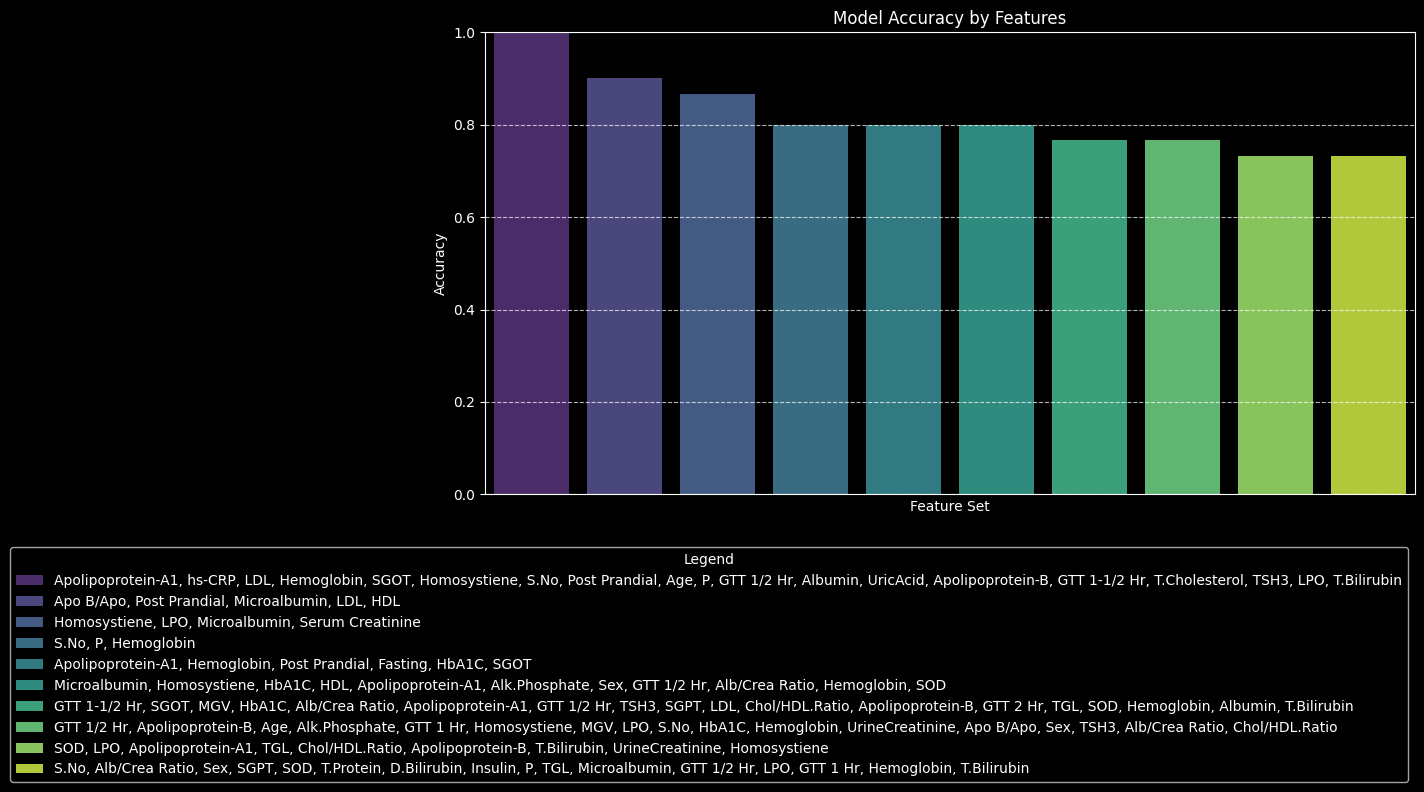

In [11]:
accuracy_results = pd.DataFrame(accuracy_results, columns=["Features", "Accuracy"])
sorted_results = accuracy_results.sort_values(by=["Accuracy"], ascending=False)
sorted_results["Features"] = sorted_results["Features"].apply(lambda x: ', '.join(x))[:10]

plt.figure(figsize=(12, 6))
sns.barplot(x="Features", y="Accuracy", data=sorted_results, palette="viridis", hue="Features")
plt.ylabel('Accuracy')
plt.xlabel('Feature Set')
plt.title('Model Accuracy by Features')
plt.ylim(0, 1)  
plt.xticks([])  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Legend', loc='upper right', bbox_to_anchor=(1, -0.1))
plt.show()

#### Correlation Matrix

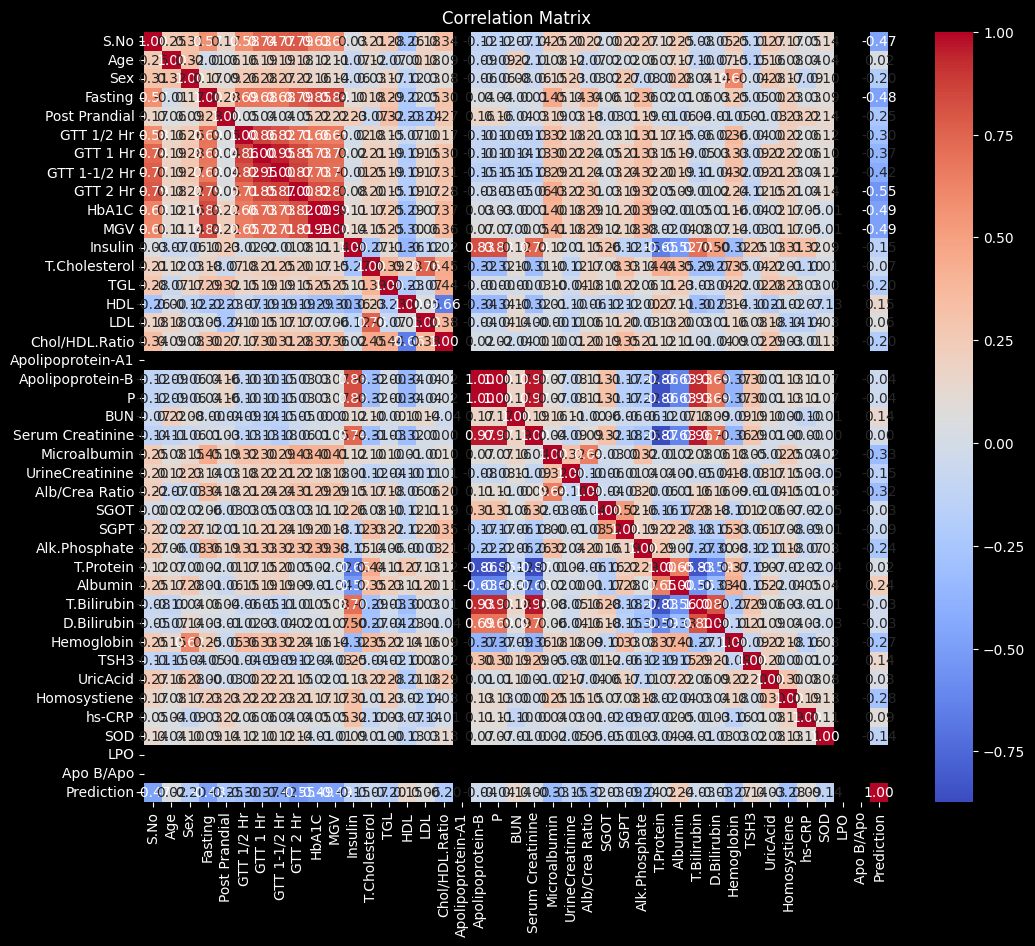

In [12]:
plt.figure(figsize=(12, 10))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

#### Distribution Plots

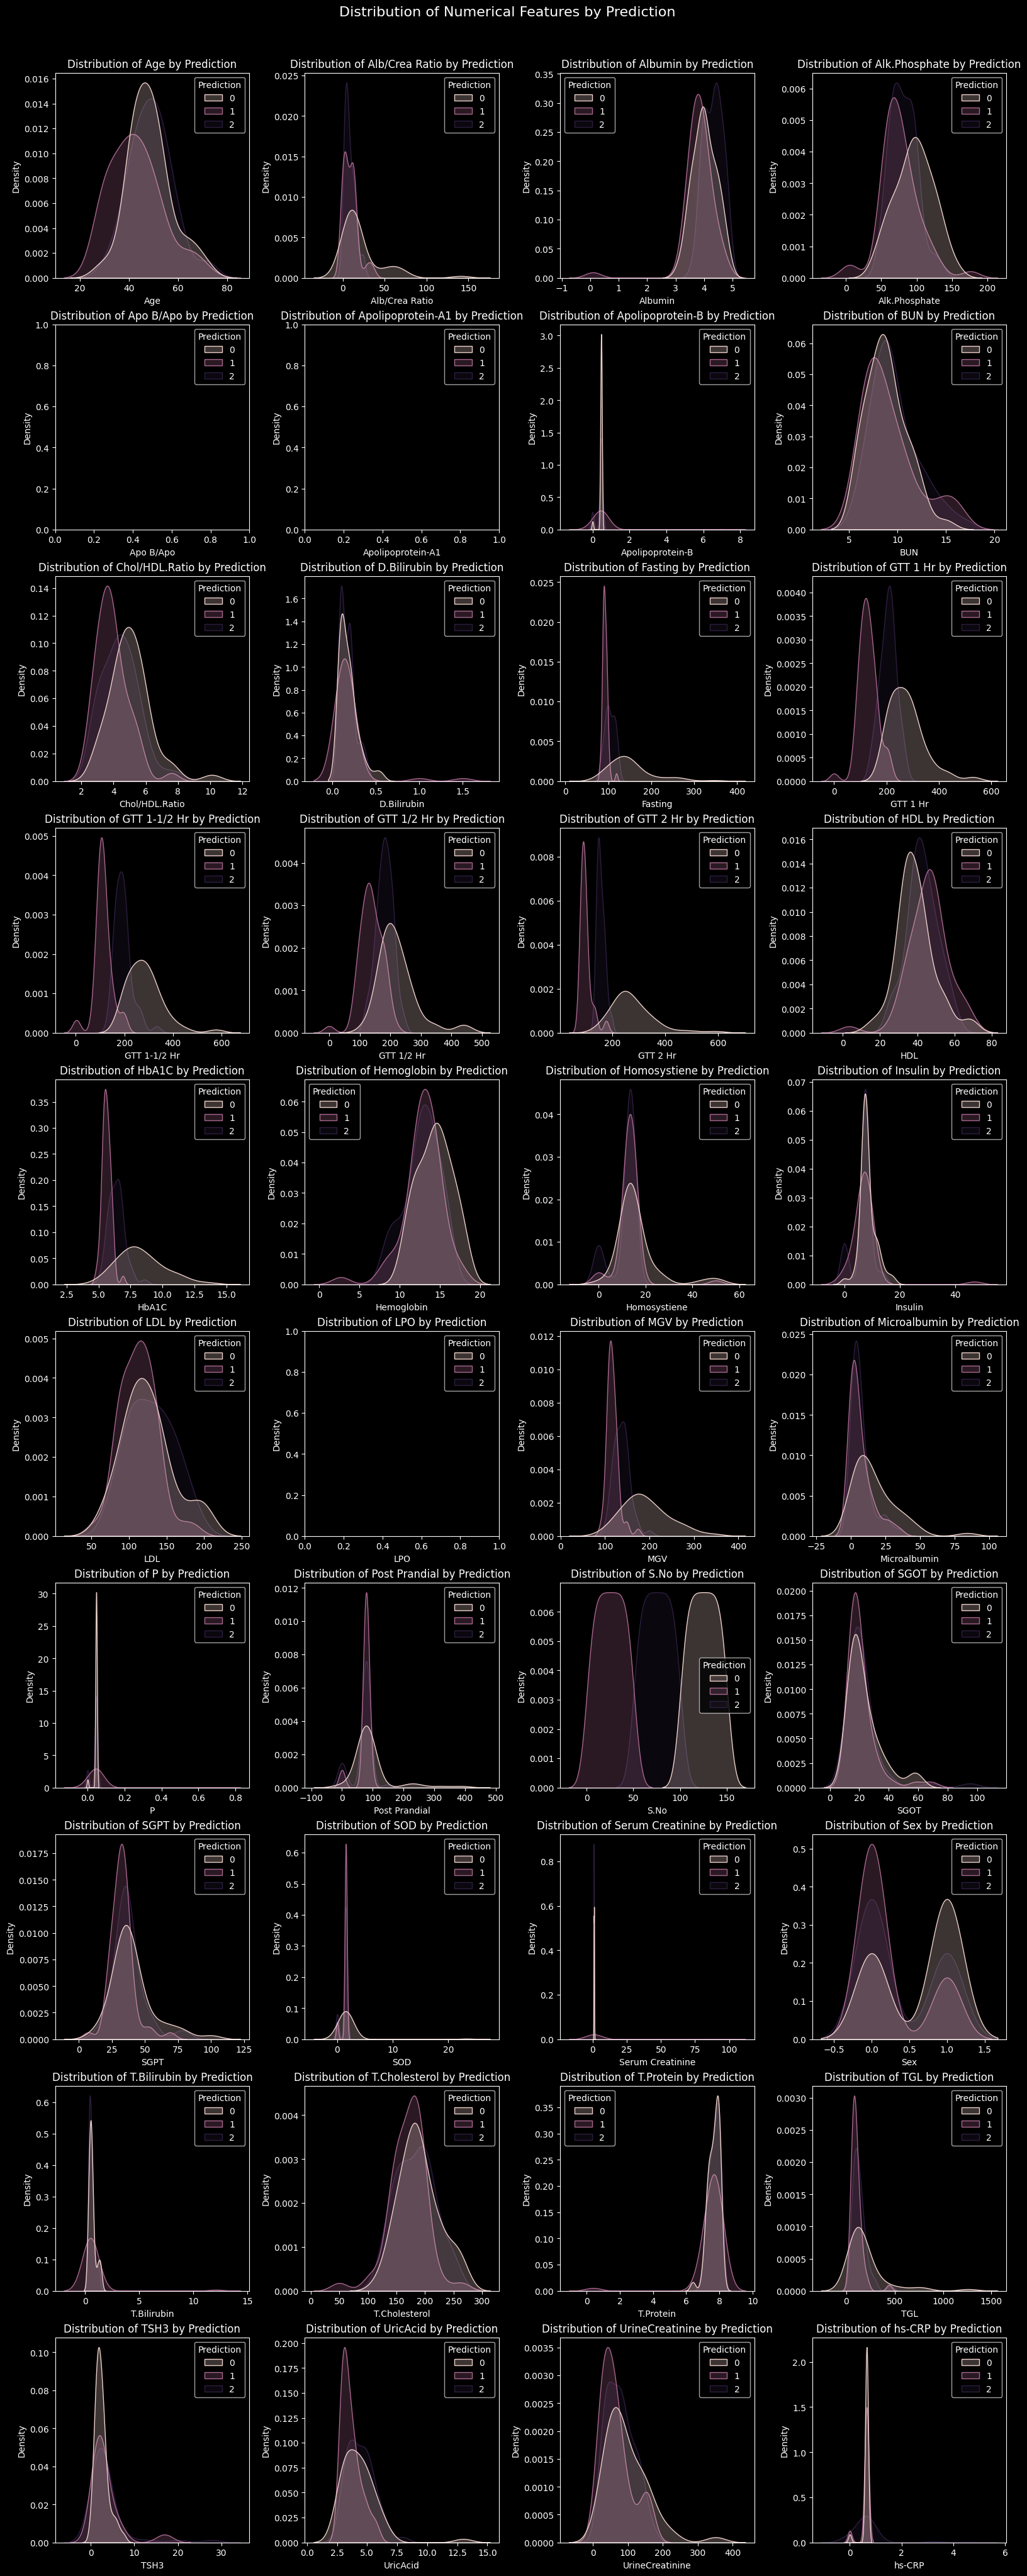

In [13]:
numeric_columns = data.select_dtypes(include=[np.number]).columns.difference(['Prediction'])

n_cols = 4  
n_rows = (len(numeric_columns) + n_cols - 1) // n_cols  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 4), constrained_layout=True)

axes = axes.flatten()

for i, col in enumerate(numeric_columns):
    sns.kdeplot(data=data, x=col, hue="Prediction", fill=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col} by Prediction')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Density")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.suptitle("Distribution of Numerical Features by Prediction", y=1.02, fontsize=16)
plt.show()

### **Comparative Analysis with Traditional Machine Learning**

In [14]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [15]:
data = pd.read_csv('Diabetes.csv')
data['Sex'] = data['Sex'].map({'female': 0, 'male': 1})

label_encoder = LabelEncoder()
data['Prediction'] = label_encoder.fit_transform(data['Prediction'])

X = data.drop(['S.No', 'Prediction'], axis=1)
y = data['Prediction']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

FileNotFoundError: [Errno 2] No such file or directory: 'Diabetes.csv'

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Naive Bayes": GaussianNB()
}

results = {}
conf_matrices = {}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    
    conf_matrices[model_name] = confusion_matrix(y_test, y_pred)

  File "c:\Users\hrish\miniconda3\envs\pennylane\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\hrish\miniconda3\envs\pennylane\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\hrish\miniconda3\envs\pennylane\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "c:\Users\hrish\miniconda3\envs\pennylane\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


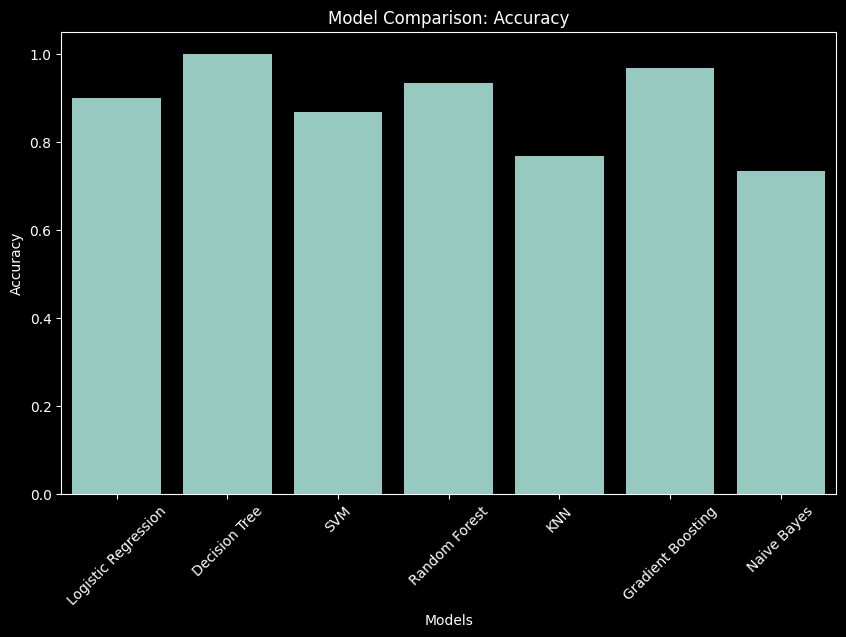

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.keys()), y=list(results.values()))
plt.title('Model Comparison: Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()

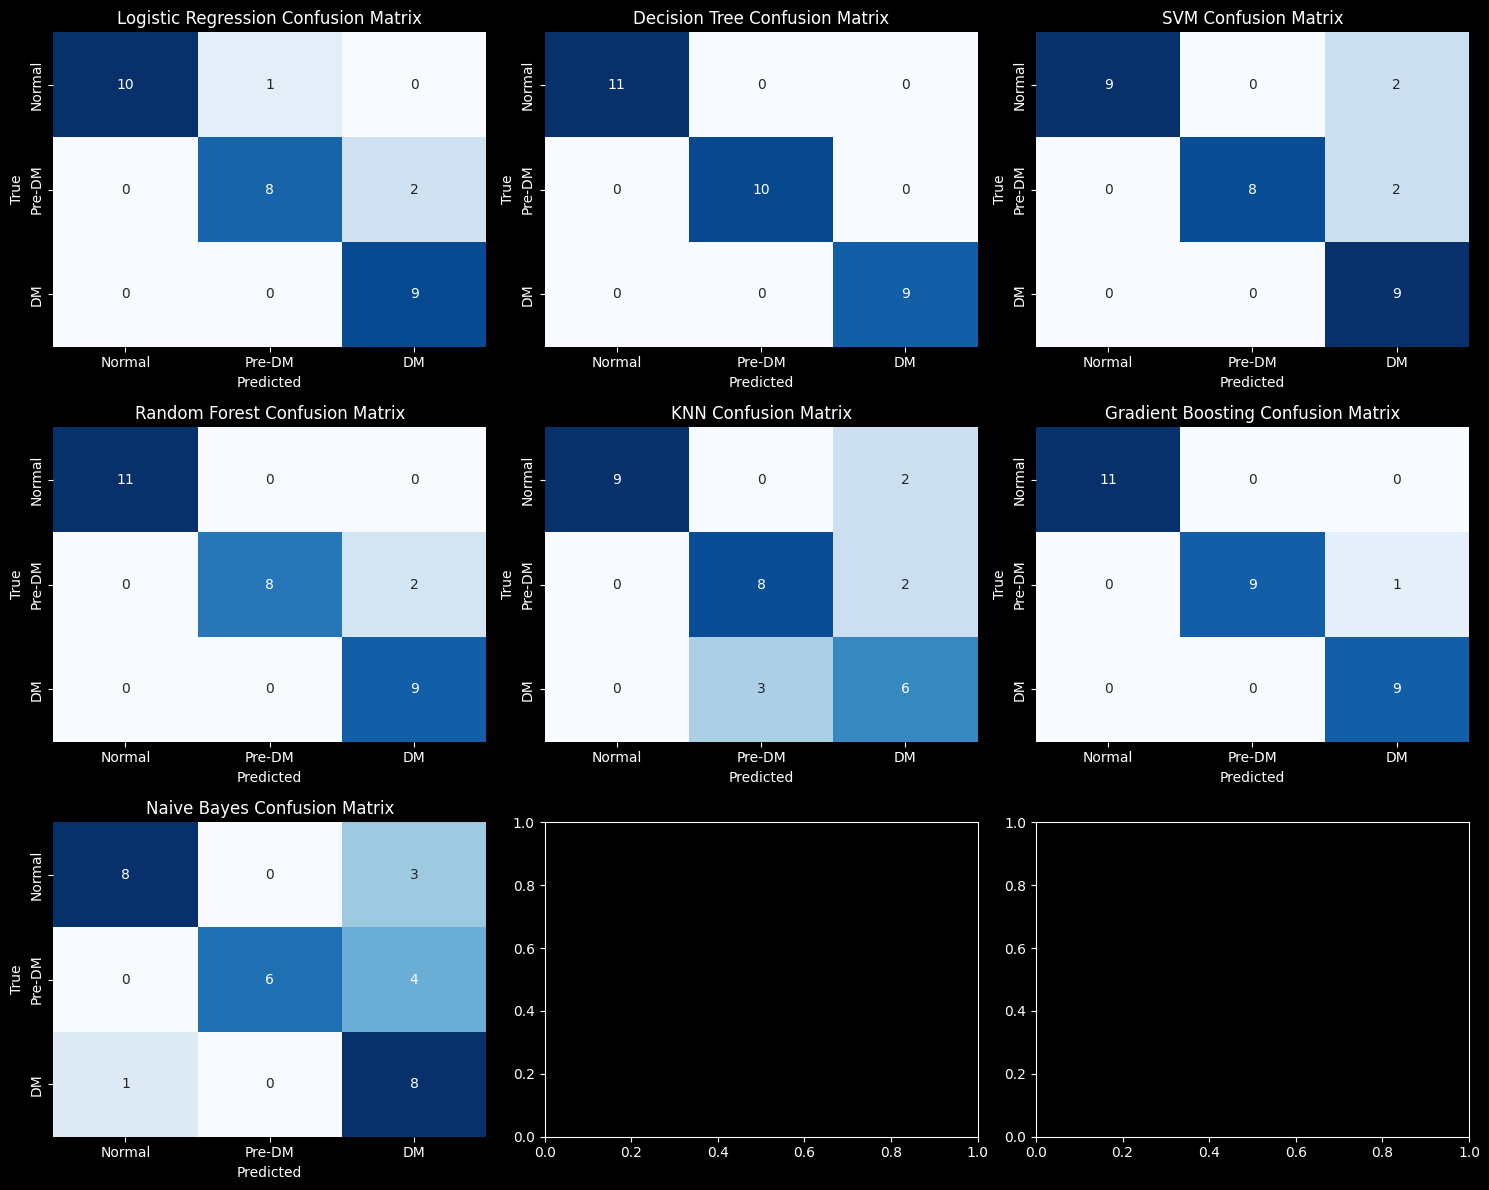

In [ ]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.ravel()

for idx, (model_name, cm) in enumerate(conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx], cbar=False,
                xticklabels=['Normal', 'Pre-DM', 'DM'], yticklabels=['Normal', 'Pre-DM', 'DM'])
    axes[idx].set_title(f'{model_name} Confusion Matrix')
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('True')
    
plt.tight_layout()
plt.show()

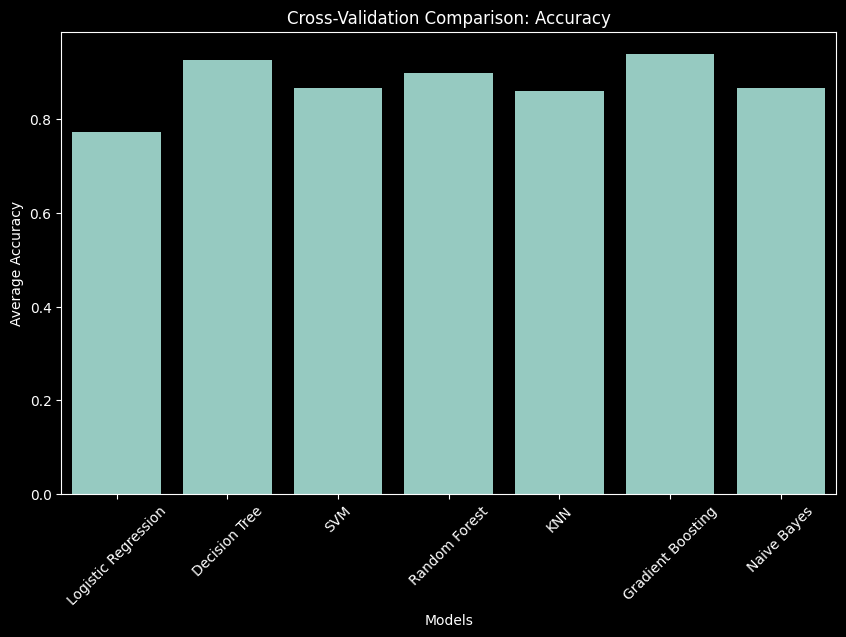

In [ ]:
cv_results = {}

for model_name, model in models.items():
    cv_score = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[model_name] = cv_score.mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=list(cv_results.keys()), y=list(cv_results.values()))
plt.title('Cross-Validation Comparison: Accuracy')
plt.ylabel('Average Accuracy')
plt.xlabel('Models')
plt.xticks(rotation=45)
plt.show()

In [ ]:
def evaluate_model(y_test, y_pred, model_name):
    print(f"{model_name} Evaluation:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

for model_name, model in models.items():
    print(f"\nEvaluating {model_name}...")
    y_pred = model.predict(X_test)
    evaluate_model(y_test, y_pred, model_name)


Evaluating Logistic Regression...
Logistic Regression Evaluation:
Accuracy: 0.9000
Confusion Matrix:
[[10  1  0]
 [ 0  8  2]
 [ 0  0  9]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95        11
           1       0.89      0.80      0.84        10
           2       0.82      1.00      0.90         9

    accuracy                           0.90        30
   macro avg       0.90      0.90      0.90        30
weighted avg       0.91      0.90      0.90        30


Evaluating Decision Tree...
Decision Tree Evaluation:
Accuracy: 1.0000
Confusion Matrix:
[[11  0  0]
 [ 0 10  0]
 [ 0  0  9]]
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        11
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         9

    accuracy                           1.00        30
   macro avg       1.00      1.00  